In [1]:
# install quandl library
%pip install quandl

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# DeepAR Algorithm

We'll be using the DeepAR Algorithm ([DeepAR](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html)) to help us predict future stock values.

Previously, I was trying to predict prices for a single stock. The model was pretty inaccurate (MAPE ~13% for 7 days out even after hypertuning). As DeepAR works best on large sets of similar time series data (recommended > 300 series), I surmise the algorithm will work much better for a portfolio of stocks. Here, we'll have to capture the individual time series for each stock in our custom portfolio above. We'll convert each stock's adjusted closing prices into a time series list.

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import quandl
import json
import os
import stock_time_series as sts
%load_ext autoreload
%autoreload 2

quandl.ApiConfig.api_key = 'z6KvEMELxCcG-Kb72EYY'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
# Build a portfolio of stocks
stocks = ['GE', 'AMD', 'GOOGL', 'AAPL', 'AMZN', 'NFLX', 'MSFT']

# Define years of interest to model against (no day/month, as it will trip our range_to_years function)
start_year = '2015'
end_year = '2017'

# visualize the data
data = pd.concat([pd.DataFrame(quandl.get("WIKI/"+stock, start_date=start_year+'-01-01', end_date=end_year+'-12-31')) for stock in stocks])
data

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2015-01-02,25.34,25.4600,24.870,25.06,40919008.0,0.0,1.0,23.140777,23.250363,22.711568,22.885078,40919008.0
2015-01-05,25.01,25.0100,24.520,24.60,42033195.0,0.0,1.0,22.839418,22.839418,22.391944,22.465001,42033195.0
2015-01-06,24.46,24.5700,23.930,24.07,63740067.0,0.0,1.0,22.337151,22.437605,21.853149,21.980999,63740067.0
2015-01-07,24.21,24.3900,23.980,24.08,43638485.0,0.0,1.0,22.108848,22.273227,21.898810,21.990131,43638485.0
2015-01-08,24.32,24.3800,24.130,24.37,43197484.0,0.0,1.0,22.209302,22.264094,22.035792,22.254962,43197484.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,85.40,85.6300,84.920,85.51,14033977.0,0.0,1.0,85.400000,85.630000,84.920000,85.510000,14033977.0
2017-12-26,85.31,85.5346,85.030,85.40,9737412.0,0.0,1.0,85.310000,85.534600,85.030000,85.400000,9737412.0
2017-12-27,85.65,85.9800,85.215,85.71,13000828.0,0.0,1.0,85.650000,85.980000,85.215000,85.710000,13000828.0


# Convert DataFrame into Time Series

Using Adjusted Close daily data, we need to create a time series where individual adjusted closing prices are separated by year. This will provide individual time series data per year for the DeepAR model to train with.

In [128]:
time_series = []
for stock in stocks:
    stock_df = pd.DataFrame(quandl.get("WIKI/"+stock, start_date=start_year+'-01-01', end_date=end_year+'-12-31'))
    time_series.append(pd.Series(stock_df['Adj. Close'], index=stock_df.index))

In [129]:
time_series

[Date
 2015-01-02    22.885078
 2015-01-05    22.465001
 2015-01-06    21.980999
 2015-01-07    21.990131
 2015-01-08    22.254962
                 ...    
 2017-12-22    17.500000
 2017-12-26    17.430000
 2017-12-27    17.380000
 2017-12-28    17.360000
 2017-12-29    17.450000
 Name: Adj. Close, Length: 754, dtype: float64,
 Date
 2015-01-02     2.69
 2015-01-05     2.66
 2015-01-06     2.63
 2015-01-07     2.58
 2015-01-08     2.61
               ...  
 2017-12-22    10.54
 2017-12-26    10.46
 2017-12-27    10.53
 2017-12-28    10.55
 2017-12-29    10.28
 Name: Adj. Close, Length: 754, dtype: float64,
 Date
 2015-01-02     529.55
 2015-01-05     519.46
 2015-01-06     506.64
 2015-01-07     505.15
 2015-01-08     506.91
                ...   
 2017-12-22    1068.86
 2017-12-26    1065.85
 2017-12-27    1060.20
 2017-12-28    1055.95
 2017-12-29    1053.40
 Name: Adj. Close, Length: 754, dtype: float64,
 Date
 2015-01-02    103.863957
 2015-01-05    100.937944
 2015-01-06    100.94

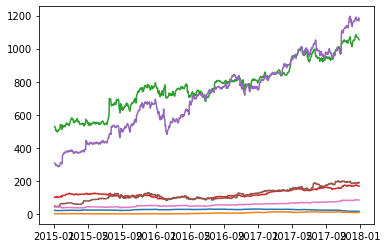

In [130]:
# Plot stock prices of individual stock for Adjusted Close price and given years to train against
for stock in time_series:
    plt.plot(stock)

In [131]:
# set prediction length
prediction_length = 7    # days

time_series_training = sts.create_training_series(time_series, prediction_length)

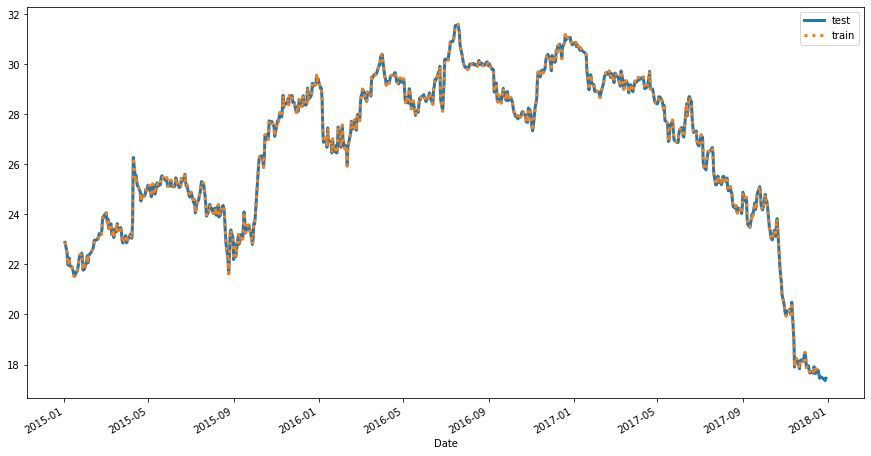

In [132]:
# display train/test time series
time_series_idx = 0

plt.figure(figsize=(15,8))
# test data is the whole time series
time_series[time_series_idx].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx].plot(label='train', ls=':', lw=3)

plt.legend()
plt.show()

# Convert DataFrame/Series to JSON

DeepAR algorithm requires JSON object input. Need to convert time series data to JSON object.

In [133]:
# test out the code
ts = time_series[0]

json_obj = sts.series_to_json_obj(ts)
print(json_obj)

{'start': '2015-01-02 00:00:00', 'target': [22.885078190233, 22.46500093694, 21.980998884234, 21.990130998436, 22.254962310294, 21.944470427426, 21.898809856416, 21.789224485992, 21.716167572376, 21.533525288335, 21.542657402537, 21.78009237179, 21.953602541628, 22.172773282476, 22.355415566516, 22.455868822738, 22.264094424496, 21.770960257588, 21.990130998436, 21.816620828598, 22.108848483062, 22.346283452314, 22.063187912052, 22.37367979492, 22.391944023324, 22.501529393748, 22.574586307364, 22.620246878374, 22.729832248799, 22.967267218051, 22.985531446455, 23.058588360071, 23.049456245869, 23.233778167067, 23.196913782828, 23.399667896146, 23.878904891262, 23.860472699142, 23.952633659741, 24.06322681246, 23.832824410962, 23.648502489764, 23.795960026723, 23.427316184326, 23.630070297644, 23.196913782828, 23.215345974947, 23.408883992206, 23.077104534049, 23.454964472505, 23.325939127667, 23.630070297644, 23.344371319786, 23.408883992206, 23.473396664625, 23.289074743427, 22.95729

In [134]:
# save this data to a local directory
data_dir = 'json_stock_data/multi-stock'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [135]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
sts.write_json_dataset(time_series_training, train_key)        
sts.write_json_dataset(time_series, test_key)

json_stock_data/multi-stock/train.json saved.
json_stock_data/multi-stock/test.json saved.


# Uploading to S3
Now we need to upload locally captured data to AWS S3

In [136]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [137]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

Specify paths for training and test data in S3

In [138]:
prefix = 'deepar'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [139]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-us-east-2-019506888477/deepar/train/train.json
Test data is stored in: s3://sagemaker-us-east-2-019506888477/deepar/test/test.json


# Training DeepAR Estimator

Create/configure a container image for the region I'm using. This container can be passed to a base Estimator that will serve as the estimator for our DeepAR model.

In [140]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [141]:
from sagemaker.estimator import Estimator

# directory to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


# Hyperparameters

## Setting Hyperparameters

We'll define some required hyperparameters to build our model.

* **epochs**: The maximum number of times to pass over the data when training.
* **time_freq**: The granularity of the time series in the dataset ('D' for daily).
* **prediction_length**: A string; the number of time steps (based off the unit of frequency) that the model is trained to predict. 
* **context_length**: The number of time points that the model gets to see *before* making a prediction. 

### Context Length

As per recommendation of the DeepAR algorithm documentation, we'll start with context_length = prediction_length. For our algorithm, we'll start with a 7 day prediction window. DeepAR receives lagged inputs from the provided time series (up to one year in some cases), so we don't have to force context_length to be longer than needed. The documentation provides more information on how DeepAR works.

### Optional Hyperparameters

Additionally, we can provide optional hyperparameters (e.g. learning_rate, num_cells, num_layers (to customize the RNN)). These are set by default if not provided. Again, reference the documentation for more information on these hyperparameters.

In [142]:
# need to feed frequency to hyperparameters
# set to 'D' for daily
freq='D'

# assign context_length. Start with it equal to prediction_length
context_length = prediction_length

# hyperparameters from tuning job
hyperparameters = {
    "epochs": "38",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "512",
    "learning_rate": "0.0005658388520229819",
    "dropout_rate": "0.16487878711930198",
    "early_stopping_patience": "10"
}

In [143]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

### Set up the tuning job

I've established the hyperparameters for the base estimator. Now I'd like to describe the tuning job that I'll need SageMaker to initiate to determine the "optimal" hyperparameters for our time series and model.

Here I'll dictate which hyperparameters I'd like to iterate through, and leave those hyperparameters alone from above that I don't need tuned for this particular job.

In [144]:
# from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

# hyperparameter_tuner = HyperparameterTuner(estimator = estimator, # The estimator object to use as the basis for the training jobs.
#                                                objective_metric_name = 'test:mean_wQuantileLoss', # The metric used to compare trained models.
#                                                objective_type = 'Minimize', # Whether we wish to minimize or maximize the metric.
#                                                max_jobs = 9, # The total number of models to train
#                                                max_parallel_jobs = 3, # The number of models to train in parallel
#                                                hyperparameter_ranges = {
#                                                     'dropout_rate': ContinuousParameter(0.1, 0.2),
#                                                     'learning_rate': ContinuousParameter(0.0005, 0.05),
#                                                     'epochs': IntegerParameter(1, 50)
#                                                })

### Execute the tuning job

Now that we have our hyperparameter tuner object completely set up, it is time to train it. To do this we make sure that SageMaker knows our input data is in csv format and then execute the `fit` method.

In [145]:
# # tell S3 where the data will be and what type of format to expect
# s3_input_train = sagemaker.s3_input(s3_data=train_path, content_type='json')
# s3_input_test = sagemaker.s3_input(s3_data=test_path, content_type='json')

# # fit
# hyperparameter_tuner.fit({'train': s3_input_train, 'test': s3_input_test})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [146]:
# # visual to know it's fitting still...
# hyperparameter_tuner.wait()

..........................................................................................................................................................................................!


In [147]:
# # output configuration of best_training_job. Use SageMaker interface to find actual parameters.
# hyperparameter_tuner.best_training_job()

'forecasting-deepar-200920-0010-006-ea7e7fb6'

## Training Job

Launch our training job with the new best_training_job!

In [148]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

### For Hyperparameter tuning ###
# establish new estimator from best_training_job (commented out previous estimator)
# estimator_best = sagemaker.estimator.Estimator.attach(hyperparameter_tuner.best_training_job())

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-09-20 00:21:08 Starting - Preparing the instances for training
2020-09-20 00:21:08 Downloading - Downloading input data
2020-09-20 00:21:08 Training - Training image download completed. Training in progress.
2020-09-20 00:21:08 Uploading - Uploading generated training model
2020-09-20 00:21:08 Completed - Training job completedArguments: train
[09/20/2020 00:18:52 INFO 139688361523008] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[09/20/2020 

## Deploy and Create a Predictor

In [149]:
%%time

# create a predictor (use estimator_best for hyperparameter tuning)
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!CPU times: user 240 ms, sys: 20.2 ms, total: 260 ms
Wall time: 6min 31s


# Generating Predictions

According to the DeepAR documentation, the DeepAR predictor expects to see inputa data in JSON format. We need to convert our time series into a JSON instance in order to obtain predicted prices.

In [150]:
# get all input and target (test) time series
input_ts = time_series_training
target_ts = time_series

# get formatted input time series
json_input_ts = sts.json_predictor_input(input_ts)

# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)

## Decoding Predictions

The predictor also returns a JSON formatted perdiction. Thus, we need to pull out the predictions from the JSON instance.

We have written a function in stock_time_series.py that takes in the predictor output and returns a list of predictions in each quantile of interest (0.1, 0.5, 0.9).

In [151]:
# get quantiles/predictions
prediction_list = sts.decode_prediction(json_prediction)

# should get a list of predictions (of length prediction_length)
# with corresponding quantile values
print(prediction_list)

[         0.1        0.9        0.5
0  17.011282  18.628233  17.702085
1  17.257040  18.410095  17.676117
2  17.049961  18.242498  17.648518
3  16.975113  18.367296  17.622953
4  16.794857  18.081453  17.540558
5  16.488232  18.460793  17.670954
6  16.886162  18.326649  17.565649,          0.1        0.9        0.5
0  10.116461  11.011309  10.487579
1  10.086954  10.886207  10.421416
2  10.075234  10.937563  10.445969
3  10.045368  10.961756  10.400452
4  10.036035  10.975547  10.393658
5   9.807874  10.838662  10.379983
6   9.924924  10.865392  10.505792,            0.1          0.9          0.5
0  1040.511108  1122.981079  1078.593872
1  1052.268799  1113.078491  1076.499878
2  1053.260620  1106.682739  1075.273682
3  1050.155273  1109.836670  1074.094604
4  1026.956299  1102.930908  1072.101929
5  1039.182861  1120.200562  1081.915894
6  1046.185303  1110.752563  1085.111450,           0.1         0.9         0.5
0  169.060944  182.859970  176.008316
1  169.881851  183.212494  174.1

## Display the Results

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.


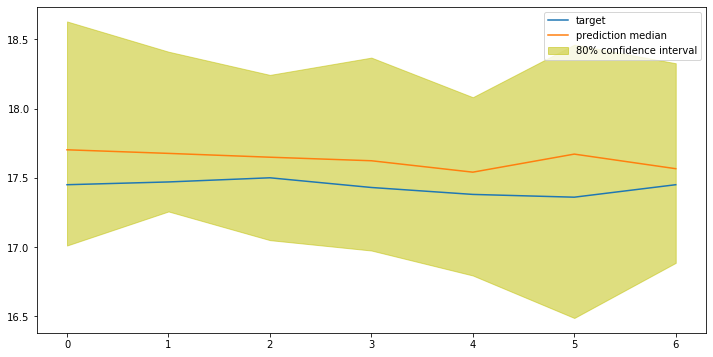

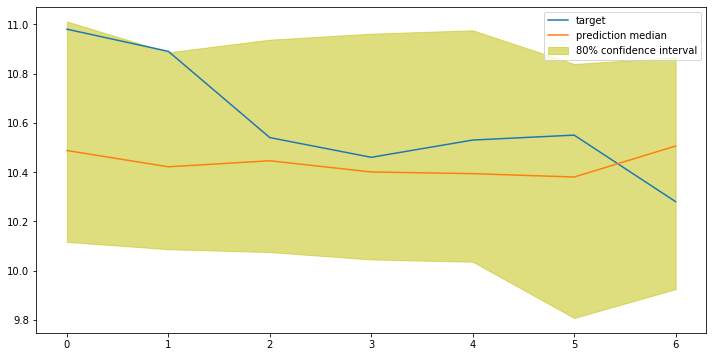

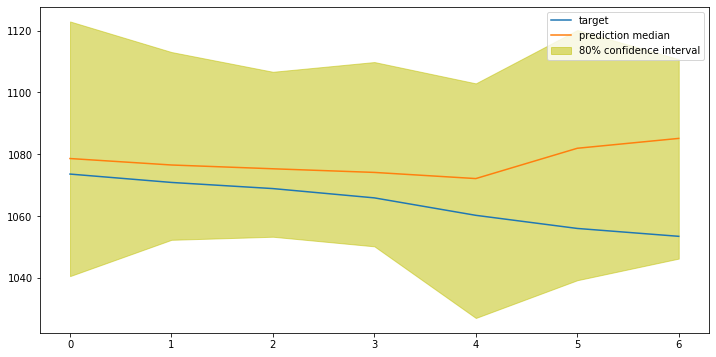

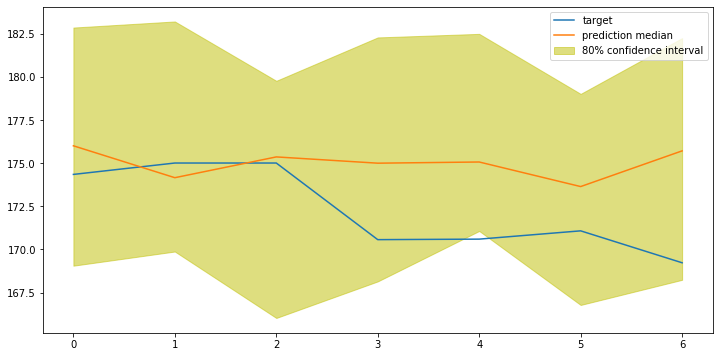

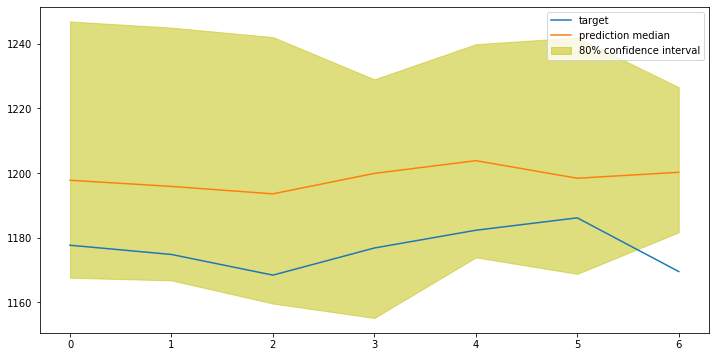

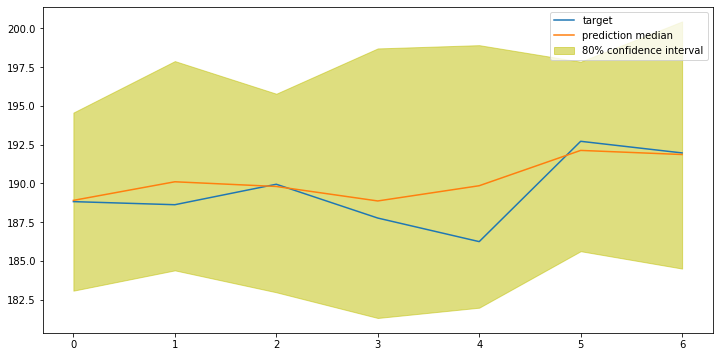

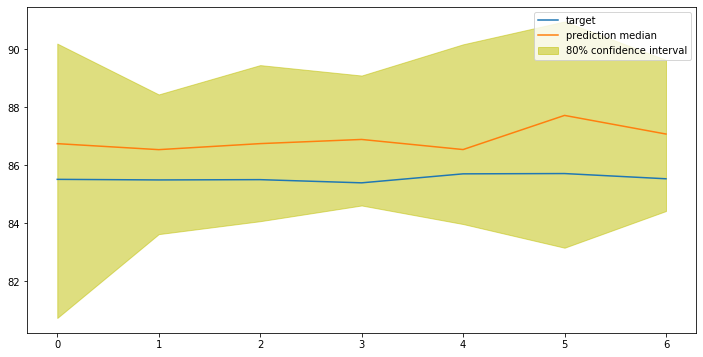

In [152]:
# display predictions (0.1, 0.9, 0.5)
sts.display_quantiles(prediction_list, prediction_length, target_ts)

## Test Prediction of "Future" Data

Now let's test our model on data it hasn't actually seen -- thus, no target to compare against.

In [153]:
# Starting my prediction on first trading day of 2018
start_date = '2018-01-03'
timestamp = '00:00:00'

# formatting start_date
start_time = start_date +' '+ timestamp

# formatting request_data
# these instances have empty targets
instances = []
for i in range(len(stocks)):
    inst_dict = {'start': start_time, 'target': []}
    instances.append(inst_dict)
    
request_data = {"instances": instances,
                "configuration": {"num_samples": 50,
                                  "output_types": ["quantiles"],
                                  "quantiles": ['0.1', '0.5', '0.9']}
                }

json_input = json.dumps(request_data).encode('utf-8')

print('Requesting prediction for '+start_time)

Requesting prediction for 2018-01-03 00:00:00


Then get and decode the prediction response, as usual.

In [154]:
# get prediction response
json_prediction = predictor.predict(json_input)

prediction_future = sts.decode_prediction(json_prediction)

print(prediction_future)

[          0.1         0.9         0.5
0  103.579727  293.720642  183.131653
1  194.132980  274.034912  222.721893
2  215.815247  265.987061  240.537003
3  229.074799  279.403687  255.345383
4  232.665375  268.097290  252.164078
5  230.833176  276.781830  257.716736
6  237.162888  270.526428  254.053726,           0.1         0.9         0.5
0  132.944763  307.325378  205.071793
1  187.513260  280.777771  231.073227
2  215.707916  280.748413  243.961761
3  224.099792  281.608002  248.738525
4  235.394287  284.659241  254.212128
5  230.738831  273.953583  257.570465
6  235.498993  273.080170  257.121521,           0.1         0.9         0.5
0  107.828430  306.608612  199.800049
1  193.841599  296.480103  230.144226
2  195.387054  262.536194  234.669037
3  218.704514  281.225159  252.330124
4  233.771973  283.158386  254.629303
5  234.110001  280.257843  256.722961
6  235.718918  274.938690  256.765289,           0.1         0.9         0.5
0  111.780098  248.785019  187.731766
1  182.7

We need to compare these predictions to the actual values from the "future".

In [155]:
# create "future" time series
ts_future = []

# range of actual data to compare
start_idx=0 # days since start
end_idx=start_idx+prediction_length

for stock in stocks:
    # get data from the "future" (2018 onward)
    stock_df = pd.DataFrame(quandl.get("WIKI/"+stock, start_date=start_date+'-01-01'))
    stock_future_df = stock_df[start_idx:end_idx] # get selected prediction range of each stock
    ts_future.append(pd.Series(stock_future_df['Adj. Close'], index=stock_future_df.index))
ts_future

[Date
 2018-01-03    18.150
 2018-01-04    18.530
 2018-01-05    18.540
 2018-01-08    18.280
 2018-01-09    18.560
 2018-01-10    18.929
 2018-01-11    19.020
 Name: Adj. Close, dtype: float64,
 Date
 2018-01-03    11.5500
 2018-01-04    12.1200
 2018-01-05    11.8800
 2018-01-08    12.2800
 2018-01-09    11.8200
 2018-01-10    11.9600
 2018-01-11    12.1404
 Name: Adj. Close, dtype: float64,
 Date
 2018-01-03    1091.52
 2018-01-04    1095.76
 2018-01-05    1110.29
 2018-01-08    1114.21
 2018-01-09    1112.79
 2018-01-10    1110.14
 2018-01-11    1111.88
 Name: Adj. Close, dtype: float64,
 Date
 2018-01-03    172.23
 2018-01-04    173.03
 2018-01-05    175.00
 2018-01-08    174.35
 2018-01-09    174.33
 2018-01-10    174.29
 2018-01-11    175.28
 Name: Adj. Close, dtype: float64,
 Date
 2018-01-03    1204.20
 2018-01-04    1209.59
 2018-01-05    1229.14
 2018-01-08    1246.87
 2018-01-09    1252.70
 2018-01-10    1254.33
 2018-01-11    1276.68
 Name: Adj. Close, dtype: float64,
 Dat

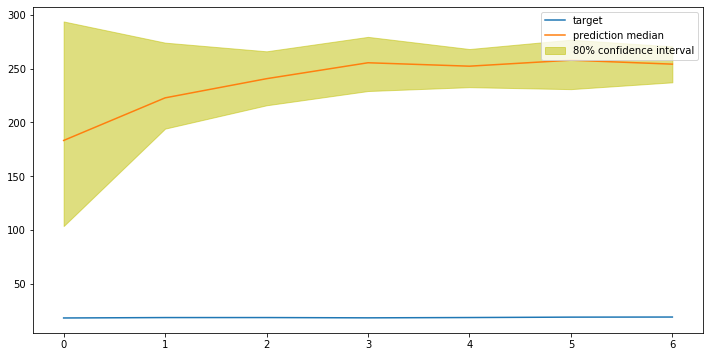

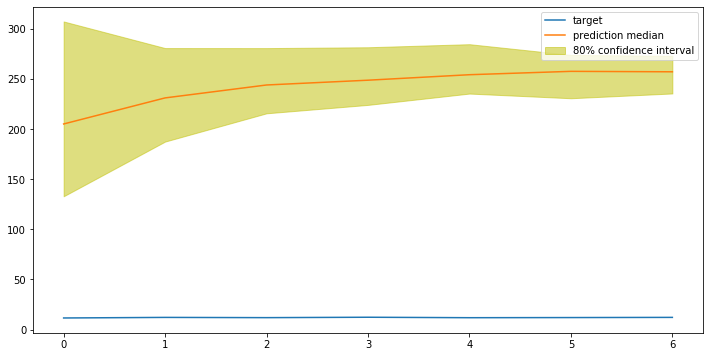

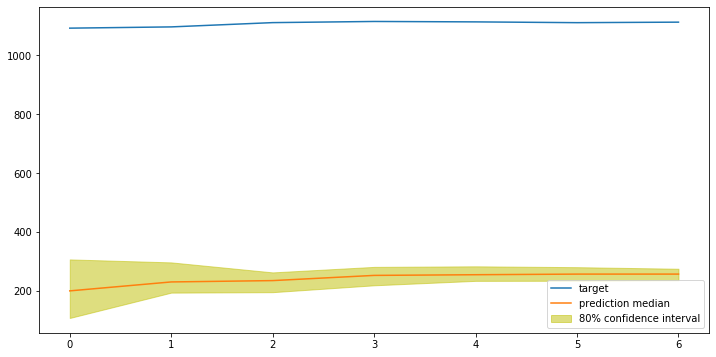

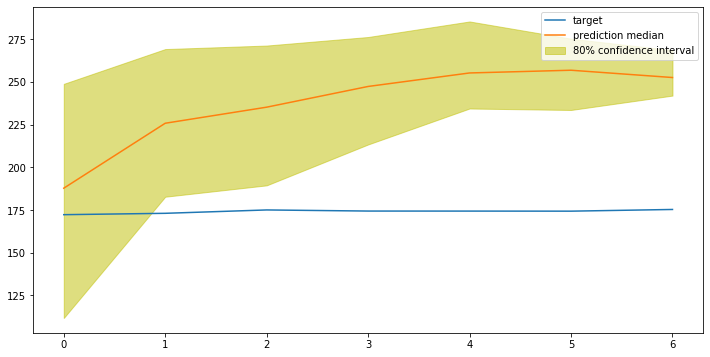

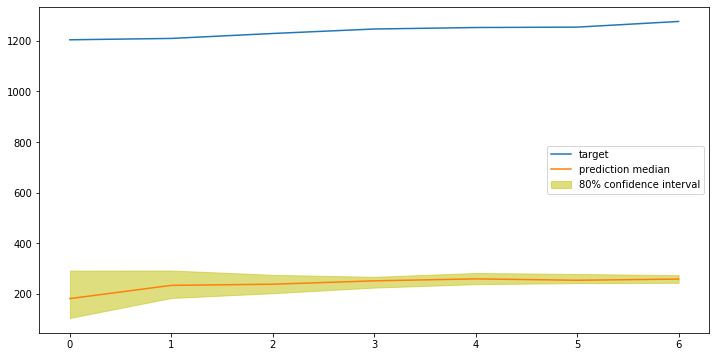

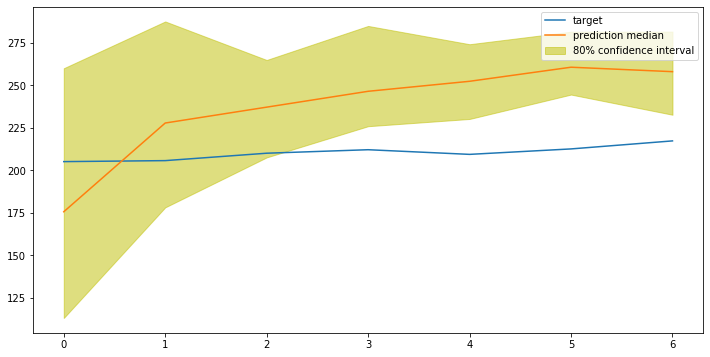

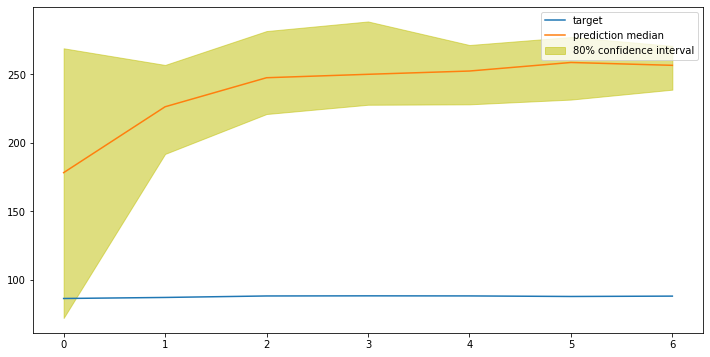

In [156]:
# display predictions
sts.display_quantiles(prediction_future, prediction_length, ts_future)

# Naive Method

$Ŷ(t+h|t) = Y(t)$

A Naive method follows a model that forecasts for every new time period correspond to the last observed value. We'll use this as a benchmark model to compare our predicted values against.

In [ ]:
def naive(prediction_future, ts_future):
    naive_data = []
    for stock in stocks:
    # get data from the "future" (2018 onward)
        stock_df = pd.DataFrame(quandl.get("WIKI/"+stock, start_date=start_date+'-01-01'))
        stock_future_df = stock_df[start_idx:end_idx] # get selected prediction range of each stock
        ts_future.append(pd.Series(stock_future_df['Adj. Close'], index=stock_future_df.index))
ts_future

# Accuracy

We'll define the accuracy of our model using a percentage difference calculation, or mean average percentage error (MAPE). MAPE provides us with a unitary stastical measure for the accuracy of an entire time series over a given period. We'll calculate per the provided formula.

${\mbox{M}}={\frac  {1}{n}}\sum _{{t=1}}^{n}\left|{\frac  {A_{t}-F_{t}}{A_{t}}}\right|$

where $n$ is the number of fitted periods, $A_t$ is the actual value and $F_t$ is the forecast value.

In [164]:
def mape(prediction_future, target_future_ts):
    df = pd.DataFrame(index=stocks, columns=['7-day'])
    
    for k in range(len(stocks)):
        ind_mape_ts = [100 * abs(prediction_future[k]['0.5'][i] - target_future_ts[k][i])/ts_future[k][i] for i in range(len(ts_future[k]))]
        total_ind_mape = sum(ind_mape_ts)/prediction_length
        df.iloc[k] = total_ind_mape
    
    return df

# Calculate MAPE (in PERCENTAGE)
mape(prediction_future, ts_future)

,7-day
GE,1180.15
AMD,1926.19
GOOGL,78.2585
AAPL,36.1993
AMZN,80.7466
NFLX,16.5997
MSFT,171.628


## Delete the Endpoint

In [50]:
## TODO: delete the endpoint
predictor.delete_endpoint()